<a href="https://colab.research.google.com/github/Jtrep10/NTK_Experiments/blob/main/NTK_empirical_stax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Library Import

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [2]:
!pip -q install --upgrade pip

In [3]:
# for Colab, use older versions as newer ones produce jax/neural_tangent versions conflicts
!pip install -q "jax[cuda12]==0.5.3" jaxlib==0.5.3
!pip install -q neural_tangents==0.6.5

In [4]:
import neural_tangents as nt
from neural_tangents import stax

from jax import jit
from jax import numpy as jnp
from jax import random as jrand

In [5]:
import os
os.makedirs("img",exist_ok=True) # create folder for images if it does not already exist

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


# Helper Functions

In [7]:
# Util funcs

# use numpy instead of torch now
def input(gamma:float)->np.array:
  x=np.array([np.cos(gamma),np.sin(gamma)])
  return x.reshape(1,-1)


def create_model(width, depth, seed, out_dim,activation,parameterization='ntk'):
  # parameterization should be 'ntk' or 'standard'
  # see here for parameterization documentation
  # https://neural-tangents.readthedocs.io/en/latest/_autosummary/neural_tangents.stax.Dense.html
  random.seed(seed)
  layer_list=[]
  for i in range(depth-1):
    layer_list.append(stax.Dense(width,parameterization=parameterization))
    layer_list.append(activation())
  layer_list.append(stax.Dense(out_dim,parameterization=parameterization))
  init_fn, apply_fn, _ = stax.serial(*layer_list)
  kwargs = dict(
      f=apply_fn,
      trace_axes=(),
      vmap_axes=0
  )
  _, params = init_fn(jrand.PRNGKey(seed), input(0).shape)
  return (kwargs,params) # outputs interface directly with functions to get NTKs

# for comparison in Jacot plots, only works for 1d output for now
def create_infinite_width_kernel(depth,activation,parameterization='ntk'):
  # parameterization should be 'ntk' or 'standard'
  # see here for parameterization documentation
  # https://neural-tangents.readthedocs.io/en/latest/_autosummary/neural_tangents.stax.Dense.html
  random.seed(seed)
  layer_list=[]
  for i in range(depth-1):
    layer_list.append(stax.Dense(1,parameterization=parameterization)) # width does not matter for infinite width
    layer_list.append(activation())
  layer_list.append(stax.Dense(1,parameterization=parameterization))
  _, _, kernel_fn = stax.serial(*layer_list)
  return kernel_fn

Very simple training function to see how the NTK looks before and after training. Needs to be updated to use stax instead of torch.

In [8]:
# def train_model(model, optimizer, loss_fn, desired_out,num_epochs, seed, device,gamma_spacing=0.01,print_loss=True):
#   # desired_out should operate on gamma to generate a target output
#   # loss function should be from torch.nn
#   torch.manual_seed(seed)
#   random.seed(seed)
#   model=model.to(device)
#   model.train()
#   gamma_vec = torch.arange(-1*np.pi, np.pi, gamma_spacing)
#   for epoch in range(num_epochs):
#     for gamma in gamma_vec:
#       x_in = input(gamma).to(device)
#       out = model.forward(x_in)
#       loss = loss_fn(out,desired_out(gamma).to(device))
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#     if print_loss:
#       print(f"Loss at the end of epoch {epoch}: {loss}")
#   model.eval()
#   return model

# NTK Calculation Functions

Updated to use neural_tangents library.

In [9]:
def get_NTK(model_args,ref_input,input):
  kwargs=model_args[0] # outputs of create_model
  params=model_args[1]
  ntvp = jit(nt.empirical_ntk_fn(
    **kwargs, implementation=nt.NtkImplementation.NTK_VECTOR_PRODUCTS))
  NTK=ntvp(ref_input,input,params)
  return NTK


def doNTK(model_args, gamma_spacing:float=0.01):
  kwargs=model_args[0] # outputs of create_model
  params=model_args[1]
  gammas = np.arange(-1*np.pi, np.pi, gamma_spacing)

  inputs=[input(gamma) for gamma in gammas]
  inputs = np.stack(inputs).squeeze()

  ntvp = jit(nt.empirical_ntk_fn(
    **kwargs, implementation=nt.NtkImplementation.NTK_VECTOR_PRODUCTS))
  NTK_arr = ntvp(input(0.0),inputs,params)

  return gammas, NTK_arr.squeeze()

def doNTK_surface(model_args, numpts):
  kwargs=model_args[0] # outputs of create_model
  params=model_args[1]
  X = np.linspace(-1, 1, numpts, dtype=np.float32)
  Y = np.linspace(-1, 1, numpts, dtype=np.float32)
  gX, gY = np.meshgrid(X, Y)
  inputs=[np.array([gX.flatten()[i],gY.flatten()[i]]) for i in range(len(gX.flatten()))]
  inputs=np.stack(inputs)

  ntvp = jit(nt.empirical_ntk_fn(
  **kwargs, implementation=nt.NtkImplementation.NTK_VECTOR_PRODUCTS))

  gZ=ntvp(input(0.0),inputs,params)
  gZ=np.reshape(gZ,gX.shape)


  return gX, gY, gZ

# if torch.cuda.is_available(): # I don't think we need this for the stax library, but we can add it later if needed
#     device = torch.device("cuda")
#     print("Using GPU:", torch.cuda.get_device_name(0))
# else:
#     device = torch.device("cpu")
#     print("Using CPU")

def get_NTK_eigenvalues(model_args, input_1, input_2, return_NTK=False,**kwargs):
  # kwargs is optional arguments used only for printing latex table text
  NTK = get_NTK(model_args, input_1, input_2)
  lambdas,_ = np.linalg.eig(NTK)
  lambdas = np.abs(lambdas)
  condition_number = np.max(lambdas)/np.min(lambdas)
  condition_str=""
  for key,value in kwargs.items():
    condition_str=condition_str+f"${value}$ & "
  condition_str=condition_str+f" ${condition_number}$ \\"
  print(condition_str)
  if not return_NTK:
    return lambdas
  else:
    return lambdas,NTK


# Experiment Cell Templates

I have considered 4 experiment setups:

*   **NTK Surface**: Using a network with an input dimension of 2 and an output dimension of 1, calculate the NTK across inputs ranging -1 to 1 and use a 3d surface plot to show results.
*   **NTK 2D Plot Varying Seed**: Using a network with an input dimension of 2 and an output dimension of 1, parameterize the inputs with $\gamma$ as $[cos(\gamma),sin(\gamma)]^T$. This allows a 2d plot of $\gamma$ against the NTK. For this experiment, I plot multiple random seeds on top of each other with the same color to show variation across seed.
*  **Eigenvalue Histogram**: This allows NTK visualization with an arbitrary output dimension. Calculate the NTK for a specified output dimension and then calculate its eigenvalues. Pool eigenvalues across a list of seeds and show the histogram. (We could also choose to use only one seed here.) As a single number to characterize the matrix, I display the condition number, or $\kappa=\lambda_{max}/\lambda_{min}$.
*  **Before and After Training**: Initialize a model, show the NTK, train the model, and then show NTK after training. Currently I am using a 2d output and showing condition number and the NTK itself before and after training, but this can be changed.

For the first two experiments, I set the output dimension to 1 so that the NTK is scalar and no points are discarded when plotting. The third experiment allows visualization of high-dimensional NTKs.

Templates for each experiment are included below (commented).


In [10]:
# # Surface plots
# ########################################### ADJUST HERE
# ACTIVATION = stax.Relu
# WIDTHS = [100, 500, 1000, 1500]
# DEPTH = 4
# SEED = 32
# SURFACE_POINTS = 50
# ###########################################

# for W in WIDTHS:
#     mod = create_model(W, DEPTH, SEED, 1, ACTIVATION) # use output_dim=1 for surface plots
#     X, Y, Z = doNTK_surface(mod, SURFACE_POINTS)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(X, Y, Z, cmap='viridis')
#     s = "img/width_"+str(W)+"_Act_"+ACTIVATION.__name__
#     plt.savefig(s+"_surface.png")
#     plt.show()
#     plt.clf()

In [11]:
# # NTK 2D Plot Varying Seed
# ########################################### ADJUST HERE
# ACTIVATION = stax.Relu
# WIDTHS = [100, 500, 1000, 1500]
# WIDTH_COLORS=['b','g','y','c'] # list of colors to show different widths on the same plot, need len(colors)>=len(widths)
# DEPTH = 4
# SEED_LIST = [10,32,0]
# SURFACE_POINTS = 50
# ###########################################


# for i in range(len(WIDTHS)):
#   W = WIDTHS[i]
#   color=WIDTH_COLORS[i]
#   for seed in SEED_LIST:
#     model = create_model(W, DEPTH, seed, 1, ACTIVATION) # use output_dim=1 for surface plots
#     gap = 2.0 / SURFACE_POINTS
#     X, Y = doNTK(model, gap)
#     bY = [Y[n].item() for n in range(len(Y))]
#     if seed==SEED_LIST[0]:
#       plt.plot(X, bY,label=f"Width={W}",color=color)
#     else:
#       plt.plot(X, bY,color=color)

# # plot infinite width, takes extra time but is interesting result
# k_fn=create_infinite_width_kernel(DEPTH,ACTIVATION)
# gammas = np.arange(-1*np.pi, np.pi, 0.05)
# ntks=[k_fn(input(0),input(gamma),'ntk') for gamma in gammas]
# ntks=np.stack(ntks).squeeze()
# plt.plot(gammas,ntks,label="Infinite width",color='black',linewidth=3)

# s=f"img/{str(ACTIVATION.__name__)}_2d_plot"
# plt.xlabel("gamma")
# plt.ylabel("NTK")
# plt.legend()
# plt.savefig(s+".png")
# print("Saved with width "+str(W))
# plt.show()
# plt.clf()


In [12]:
# # Eigenvalue Histogram
# ########################################### ADJUST HERE
# ACTIVATION = stax.Relu
# WIDTHS = [100, 500, 1000, 1500]
# DEPTH = 4
# SEED_LIST = [32,43,50,0]
# SURFACE_POINTS = 50
# OUT_DIM=20
# ###########################################

# for W in WIDTHS:
#   lambdas_W=[]
#   print(f"Starting width={W}")
#   for SEED in SEED_LIST:
#     mod = create_model(W,DEPTH,SEED,OUT_DIM,ACTIVATION)
#     lambdas = get_NTK_eigenvalues(mod,input(gamma=0),input(gamma=1),width=W,seed=SEED,act="Relu") # can change gammas for input
#     lambdas_W.append(lambdas)
#   lambdas_W=np.concatenate(lambdas,axis=0).squeeze() # remove extra dimension
#   s = "img/Act_"+ACTIVATION.__name__
#   plt.hist(lambdas_W,label=f"Width={W}")
#   plt.title(f"Depth={DEPTH}, Output dimension={OUT_DIM}")
#   plt.legend()
#   plt.savefig(s+"_eigen.png")

In [13]:
# # Before and after training
# # Will need to be updated after we have a training function
# #############
# # Change parameters here
# seeds = [10, 32, 43, 56]
# num_epochs=10
# activation=stax.Relu
# width=100
# depth=4
# out_dim=2
# learning_rate=1e-5 # loss does not decrease when I set this too high
# weight_decay=0
# desired_out = lambda gamma: np.array([np.cos(gamma)*np.sin(gamma), # Using (x_1*x_2,(x_1*x_2)^2) as a simple example, can be changed
#                                           np.square(np.cos(gamma)*np.sin(gamma))])
# loss = nn.MSELoss(reduction='mean')
# ###############

# for seed in seeds:
#   print(f"Using seed: {seed}")
#   model = create_model(width, depth, seed,out_dim, activation)
#   optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # can try with weight decay later
#   lambdas,NTK = get_NTK_eigenvalues(model,input(0),input(1),return_NTK=True)
#   print(f"NTK before training: {NTK}")
#   model = train_model(model,optimizer,loss,desired_out,10,seed,device,print_loss=False)
#   lambdas,NTK = get_NTK_eigenvalues(model,input(0),input(1),device,return_NTK=True)
#   print(f"NTK after training: {NTK}")

# Experiment Results

NTK surface experiments:

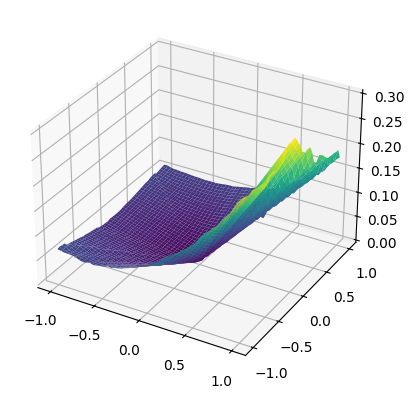

<Figure size 640x480 with 0 Axes>

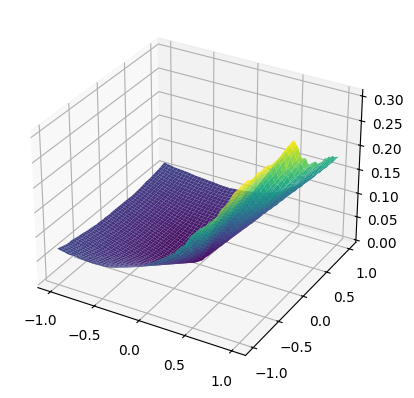

<Figure size 640x480 with 0 Axes>

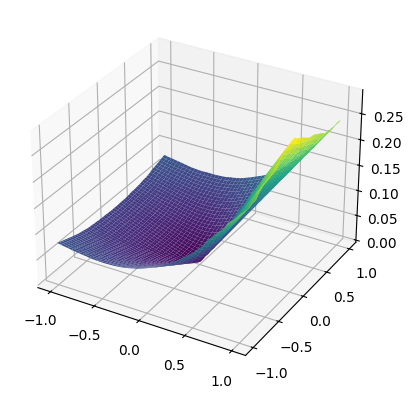

<Figure size 640x480 with 0 Axes>

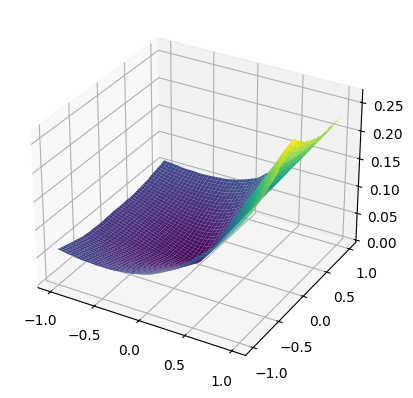

<Figure size 640x480 with 0 Axes>

In [14]:
# Surface plots
########################################### ADJUST HERE
ACTIVATION = stax.Relu
WIDTHS = [100, 500, 1000, 1500]
DEPTH = 4
SEED = 32
SURFACE_POINTS = 50
###########################################

for W in WIDTHS:
    mod = create_model(W, DEPTH, SEED, 1, ACTIVATION) # use output_dim=1 for surface plots
    X, Y, Z = doNTK_surface(mod, SURFACE_POINTS)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    s = "img/width_"+str(W)+"_Act_"+ACTIVATION.__name__
    plt.savefig(s+"_surface.png")
    plt.show()
    plt.clf()

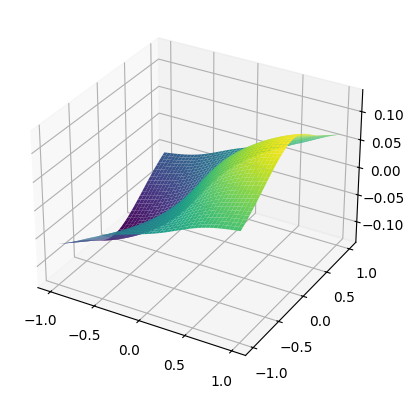

<Figure size 640x480 with 0 Axes>

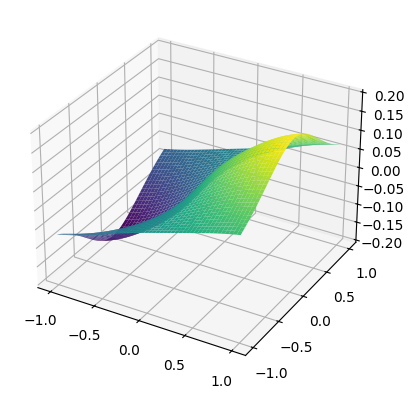

<Figure size 640x480 with 0 Axes>

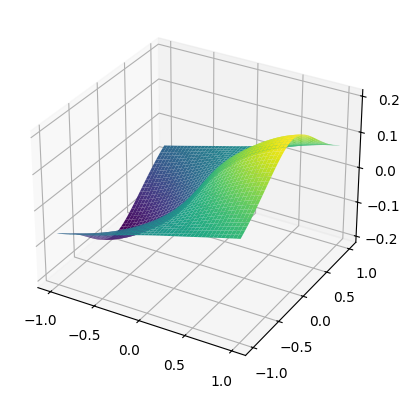

<Figure size 640x480 with 0 Axes>

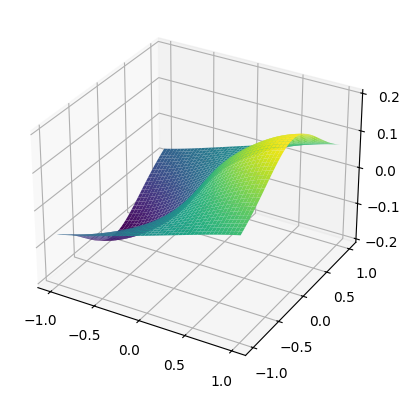

<Figure size 640x480 with 0 Axes>

In [15]:
# Surface plots
########################################### ADJUST HERE
ACTIVATION = stax.Gabor
WIDTHS = [100, 500, 1000, 1500]
DEPTH = 4
SEED = 32
SURFACE_POINTS = 50
###########################################

for W in WIDTHS:
    mod = create_model(W, DEPTH, SEED, 1, ACTIVATION) # use output_dim=1 for surface plots
    X, Y, Z = doNTK_surface(mod, SURFACE_POINTS)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    s = "img/width_"+str(W)+"_Act_"+ACTIVATION.__name__
    plt.savefig(s+"_surface.png")
    plt.show()
    plt.clf()

NTK 2D Plot Varying Seed experiments:

Saved with width 2000


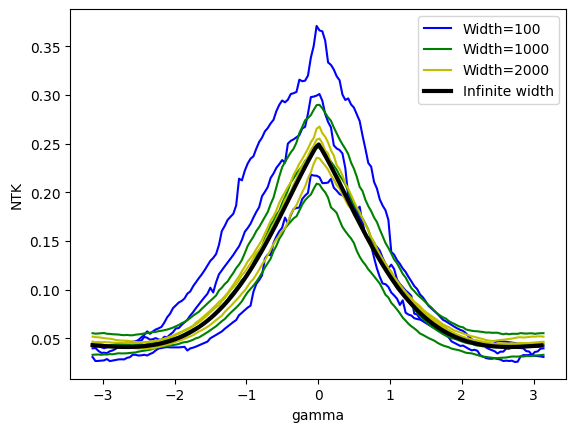

<Figure size 640x480 with 0 Axes>

In [16]:
# NTK 2D Plot Varying Seed
########################################### ADJUST HERE
ACTIVATION = stax.Relu
WIDTHS = [100,1000,2000]
WIDTH_COLORS=['b','g','y','c'] # list of colors to show different widths on the same plot, need len(colors)>=len(widths)
DEPTH = 4
SEED_LIST = [10,32,5]
SURFACE_POINTS = 50
###########################################

for i in range(len(WIDTHS)):
  W = WIDTHS[i]
  color=WIDTH_COLORS[i]
  for seed in SEED_LIST:
    model = create_model(W, DEPTH, seed, 1, ACTIVATION) # use output_dim=1 for surface plots
    gap = 2.0 / SURFACE_POINTS
    X, Y = doNTK(model, gap)
    bY = [Y[n].item() for n in range(len(Y))]
    if seed==SEED_LIST[0]:
      plt.plot(X, bY,label=f"Width={W}",color=color)
    else:
      plt.plot(X, bY,color=color)

# plot infinite width, takes extra time but is interesting result
k_fn=create_infinite_width_kernel(DEPTH,ACTIVATION)
gammas = np.arange(-1*np.pi, np.pi, 0.05)
ntks=[k_fn(input(0),input(gamma),'ntk') for gamma in gammas]
ntks=np.stack(ntks).squeeze()
plt.plot(gammas,ntks,label="Infinite width",color='black',linewidth=3)

s=f"img/{str(ACTIVATION.__name__)}_2d_plot"
plt.xlabel("gamma")
plt.ylabel("NTK")
plt.legend()
plt.savefig(s+".png")
print("Saved with width "+str(W))
plt.show()
plt.clf()


Saved with width 2000


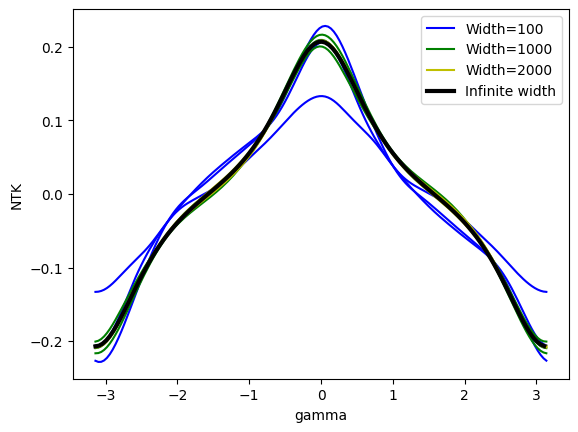

<Figure size 640x480 with 0 Axes>

In [17]:
# NTK 2D Plot Varying Seed
########################################### ADJUST HERE
ACTIVATION = stax.Gabor
WIDTHS = [100,1000,2000]
WIDTH_COLORS=['b','g','y','c'] # list of colors to show different widths on the same plot, need len(colors)>=len(widths)
DEPTH = 4
SEED_LIST = [10,32,0]
SURFACE_POINTS = 50
###########################################

for i in range(len(WIDTHS)):
  W = WIDTHS[i]
  color=WIDTH_COLORS[i]
  for seed in SEED_LIST:
    model = create_model(W, DEPTH, seed, 1, ACTIVATION) # use output_dim=1 for surface plots
    gap = 2.0 / SURFACE_POINTS
    X, Y = doNTK(model, gap)
    bY = [Y[n].item() for n in range(len(Y))]
    if seed==SEED_LIST[0]:
      plt.plot(X, bY,label=f"Width={W}",color=color)
    else:
      plt.plot(X, bY,color=color)

# plot infinite width, takes extra time but is interesting result
k_fn=create_infinite_width_kernel(DEPTH,ACTIVATION)
gammas = np.arange(-1*np.pi, np.pi, 0.05)
ntks=[k_fn(input(0),input(gamma),'ntk') for gamma in gammas]
ntks=np.stack(ntks).squeeze()
plt.plot(gammas,ntks,label="Infinite width",color='black',linewidth=3)

s=f"img/{str(ACTIVATION.__name__)}_2d_plot"
plt.xlabel("gamma")
plt.ylabel("NTK")
plt.legend()
plt.savefig(s+".png")
print("Saved with width "+str(W))
plt.show()
plt.clf()


Eigenvalue histograms:

Starting width=100
$100$ & $32$ &  $7.044629096984863$ \
$100$ & $43$ &  $4.898622989654541$ \
$100$ & $50$ &  $4.44795036315918$ \
$100$ & $0$ &  $4.280515193939209$ \
Starting width=500
$500$ & $32$ &  $2.4783670902252197$ \
$500$ & $43$ &  $2.1019413471221924$ \
$500$ & $50$ &  $2.052016258239746$ \
$500$ & $0$ &  $2.4903528690338135$ \
Starting width=1000
$1000$ & $32$ &  $1.6549063920974731$ \
$1000$ & $43$ &  $1.6354700326919556$ \
$1000$ & $50$ &  $1.7176674604415894$ \
$1000$ & $0$ &  $1.714285969734192$ \
Starting width=2000
$2000$ & $32$ &  $1.4584141969680786$ \
$2000$ & $43$ &  $1.5039697885513306$ \
$2000$ & $50$ &  $1.531239628791809$ \
$2000$ & $0$ &  $1.4712597131729126$ \


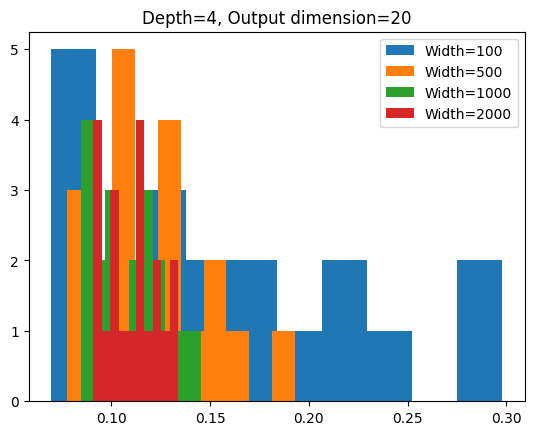

In [18]:
# Eigenvalue Histogram
########################################### ADJUST HERE
ACTIVATION = stax.Relu
WIDTHS = [100, 500, 1000, 2000]
DEPTH = 4
SEED_LIST = [32,43,50,0]
SURFACE_POINTS = 50
OUT_DIM=20
###########################################

for W in WIDTHS:
  lambdas_W=[]
  print(f"Starting width={W}")
  for SEED in SEED_LIST:
    mod = create_model(W,DEPTH,SEED,OUT_DIM,ACTIVATION)
    lambdas = get_NTK_eigenvalues(mod,input(gamma=0),input(gamma=1),width=W,seed=SEED) # can change gammas for input
    lambdas_W.append(lambdas)
  lambdas_W=np.concatenate(lambdas,axis=0).squeeze() # remove extra dimension
  s = "img/Act_"+ACTIVATION.__name__
  plt.hist(lambdas_W,label=f"Width={W}")
  plt.title(f"Depth={DEPTH}, Output dimension={OUT_DIM}")
  plt.legend()
  plt.savefig(s+"_eigen.png")


Starting width=100
$100$ & $32$ &  $13.488690376281738$ \
$100$ & $43$ &  $4.872591018676758$ \
$100$ & $50$ &  $6.942842483520508$ \
$100$ & $0$ &  $10.646995544433594$ \
Starting width=500
$500$ & $32$ &  $2.990779399871826$ \
$500$ & $43$ &  $2.8536293506622314$ \
$500$ & $50$ &  $2.721529722213745$ \
$500$ & $0$ &  $2.650435447692871$ \
Starting width=1000
$1000$ & $32$ &  $1.9520022869110107$ \
$1000$ & $43$ &  $1.931921124458313$ \
$1000$ & $50$ &  $1.9570605754852295$ \
$1000$ & $0$ &  $1.8995747566223145$ \
Starting width=2000
$2000$ & $32$ &  $1.6341137886047363$ \
$2000$ & $43$ &  $1.5371276140213013$ \
$2000$ & $50$ &  $1.611187219619751$ \
$2000$ & $0$ &  $1.6167545318603516$ \


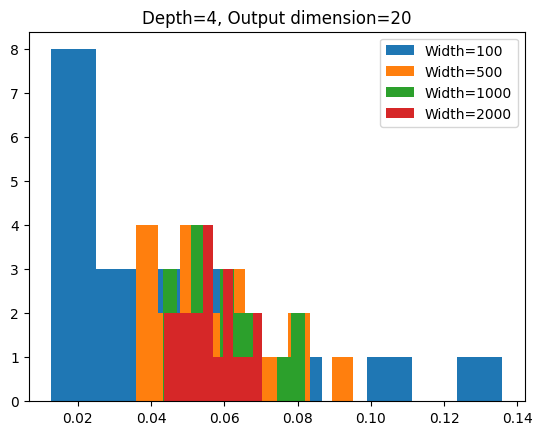

In [19]:
# Eigenvalue Histogram
########################################### ADJUST HERE
ACTIVATION = stax.Gabor
WIDTHS = [100, 500, 1000, 2000]
DEPTH = 4
SEED_LIST = [32,43,50,0]
SURFACE_POINTS = 50
OUT_DIM=20
###########################################

for W in WIDTHS:
  lambdas_W=[]
  print(f"Starting width={W}")
  for SEED in SEED_LIST:
    mod = create_model(W,DEPTH,SEED,OUT_DIM,ACTIVATION)
    lambdas = get_NTK_eigenvalues(mod,input(gamma=0),input(gamma=1),width=W,seed=SEED) # can change gammas for input
    lambdas_W.append(lambdas)
  lambdas_W=np.concatenate(lambdas,axis=0).squeeze() # remove extra dimension
  s = "img/Act_"+ACTIVATION.__name__
  plt.hist(lambdas_W,label=f"Width={W}")
  plt.title(f"Depth={DEPTH}, Output dimension={OUT_DIM}")
  plt.legend()
  plt.savefig(s+"_eigen.png")

In [20]:
# # Before and after training
# #############
# # Change parameters here
# seeds = [10, 32, 43, 56]
# num_epochs=10
# activation=nn.ReLU
# width=100
# depth=4
# out_dim=2
# learning_rate=1e-5 # loss does not decrease when I set this too high
# weight_decay=0
# desired_out = lambda gamma: torch.tensor([torch.cos(gamma)*torch.sin(gamma), # Using (x_1*x_2,(x_1*x_2)^2) as a simple example, can be changed
#                                           torch.square(torch.cos(gamma)*torch.sin(gamma))])
# ###############

# for seed in seeds:
#   print(f"Using seed: {seed}")
#   model = create_model(width, depth, seed,out_dim, activation)
#   optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # can try with weight decay later
#   lambdas,NTK = get_NTK_eigenvalues(model,input(0),input(1),device,return_NTK=True)
#   print(f"NTK before training: {NTK}")
#   model = train_model(model,optimizer,loss,desired_out,10,seed,device,print_loss=False)
#   lambdas,NTK = get_NTK_eigenvalues(model,input(0),input(1),device,return_NTK=True)
#   print(f"NTK after training: {NTK}")

In [21]:
# # Before and after training
# #############
# # Change parameters here
# seeds = [10, 32, 43, 56]
# num_epochs=10
# activation=stax.Relu
# width=100
# depth=4
# out_dim=2
# learning_rate=1e-5 # loss does not decrease when I set this too high
# weight_decay=0.1
# desired_out = lambda gamma: np.array([np.cos(gamma)*np.sin(gamma), # Using (x_1*x_2,(x_1*x_2)^2) as a simple example, can be changed
#                                           np.square(np.cos(gamma)*np.sin(gamma))])
# ##############

# for seed in seeds:
#   print(f"Using seed: {seed}")
#   model = create_model(width, depth, seed,out_dim, activation)
#   optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # can try with weight decay later
#   lambdas,NTK = get_NTK_eigenvalues(model,input(0),input(1),return_NTK=True)
#   print(f"NTK before training: {NTK}")
#   model = train_model(model,optimizer,loss,desired_out,10,seed,device,print_loss=False)
#   lambdas,NTK = get_NTK_eigenvalues(model,input(0),input(1),device,return_NTK=True)
#   print(f"NTK after training: {NTK}")